<a href="https://colab.research.google.com/github/abyanjan/Natural-language-Processing-NLP-/blob/master/Text_classification_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Text Classification with Word Embeddings and Deep Learning (Tensorflow)

Tweet Sentiment Classification

The dataset is from the Tweet Sentiment Extraction challenge from Kaggle(https://www.kaggle.com/c/tweet-sentiment-extraction/overview)

### Import Libraries

In [1]:
import os
import shutil
import string
import re

In [2]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [3]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers, losses, regularizers


In [4]:
print(tf.__version__)

2.4.1


### Preprocess Data

In [5]:
os.chdir("/content/drive/MyDrive/NLP with Deep Learning/Text classification-Tensorflow")

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [7]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [8]:
print('===========Train Data =========')
print(train_df['sentiment'].value_counts())
print(len(train_df))
print('==============================')

===========Train Data =========
neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64
27481


**Cleaning Text**

In [9]:
# Defining function for cleaning the text

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text): 
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string


def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

Processing the data

In [10]:
train_df = train_df.dropna(axis=0, how='any')
train_df['text'] = train_df['text'].apply(remove_emoji)
train_df['text'] = train_df['text'].apply(remove_url)
train_df['text'] = train_df['text'].apply(clean_text)

In [11]:
test_df = test_df.dropna(axis=0, how='any')
test_df['text'] = test_df['text'].apply(remove_emoji)
test_df['text'] = test_df['text'].apply(remove_url)
test_df['text'] = test_df['text'].apply(clean_text)

In [12]:
print('===========Train Data =========')
print(train_df['sentiment'].value_counts())
print(len(train_df))
print('==============================')


print('===========Test Data =========')
print(test_df['sentiment'].value_counts())
print(len(test_df))
print('==============================')

===========Train Data =========
neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64
27480
===========Test Data =========
neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64
3534


**Splitting training data further into train and validation set**

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df['text'], 
                                                      train_df['sentiment'], 
                                                      test_size = 0.3, 
                                                      stratify = train_df['sentiment'],
                                                      random_state = 0)

In [14]:
print('Train data len:'+str(len(X_train)))
print('Class distribution: ')
print(y_train.value_counts())
print('\n')

print('Valid data len:'+str(len(X_valid)))
print('Class distribution: ')
print(y_valid.value_counts())

Train data len:19236
Class distribution: 
neutral     7782
positive    6007
negative    5447
Name: sentiment, dtype: int64


Valid data len:8244
Class distribution: 
neutral     3335
positive    2575
negative    2334
Name: sentiment, dtype: int64


Converting the data to arrays

In [15]:
X_train = X_train.to_numpy()
X_valid = X_valid.to_numpy()
X_test = test_df['text'].to_numpy()

**Label Encoding the target label**

In [16]:
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = tf.keras.utils.to_categorical(train_labels)

valid_labels = le.fit_transform(y_valid)
valid_labels = tf.keras.utils.to_categorical(valid_labels)

test_labels = le.fit_transform(test_df['sentiment'])
test_labels = tf.keras.utils.to_categorical(test_labels)

In [17]:
le.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [18]:
train_labels

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

### Training the model

Using a pre-trained text embedding as the first layer to pocess the text for the deep learning.

In [19]:
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[],   
                           dtype=tf.string, trainable=True)

In [25]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
#model.add(tf.keras.layers.Dropout(0.5))
#model.add(tf.keras.layers.Dense(200, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
#model.add(tf.keras.layers.Dropout(0.5))
#model.add(tf.keras.layers.Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.02)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3,activation='softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 153       
Total params: 48,193,303
Trainable params: 48,193,303
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=["CategoricalAccuracy"])

In [27]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    mode="auto")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_delta=0.001,
                              patience=2,min_lr = 1e-6)

callbacks = [es,reduce_lr]

In [28]:
history = model.fit(X_train, train_labels,
                    validation_data= (X_valid,valid_labels),
                    batch_size=64,
                    epochs=20,
                    callbacks = callbacks)

Epoch 1/20
301/301 [==============================] - 9s 30ms/step - loss: 2.1502 - categorical_accuracy: 0.6929 - val_loss: 0.8914 - val_categorical_accuracy: 0.6611
Epoch 2/20
301/301 [==============================] - 9s 30ms/step - loss: 0.5863 - categorical_accuracy: 0.8326 - val_loss: 0.8805 - val_categorical_accuracy: 0.6536
Epoch 3/20
301/301 [==============================] - 9s 30ms/step - loss: 0.4891 - categorical_accuracy: 0.8627 - val_loss: 0.9111 - val_categorical_accuracy: 0.6463
Epoch 4/20
301/301 [==============================] - 9s 30ms/step - loss: 0.4393 - categorical_accuracy: 0.8813 - val_loss: 0.9365 - val_categorical_accuracy: 0.6450
Epoch 5/20
301/301 [==============================] - 9s 30ms/step - loss: 0.3855 - categorical_accuracy: 0.8951 - val_loss: 0.9685 - val_categorical_accuracy: 0.6386


**Using Keras Embedding layer**

(array([1675., 3756., 3757., 3167., 2521., 2107., 1509.,  617.,  119.,
           8.]),
 array([  0. ,  12.9,  25.8,  38.7,  51.6,  64.5,  77.4,  90.3, 103.2,
        116.1, 129. ]),
 <a list of 10 Patch objects>)

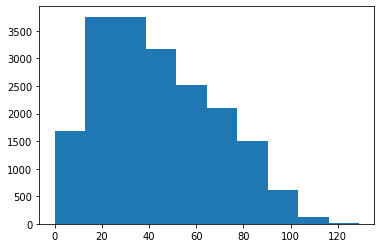

In [34]:
import matplotlib.pyplot as plt

text_lengths = ([len(text) for text in X_train])
plt.hist(text_lengths)

In [49]:
VOCAB_SIZE = 10000
MAX_LENGTH=40

In [50]:
from tensorflow.keras.preprocessing.text import one_hot
encoded_input = [one_hot(input, VOCAB_SIZE) for input in X_train]

In [51]:
# padding
padded_input = tf.keras.preprocessing.sequence.pad_sequences(encoded_input, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [52]:
padded_input

array([[5227, 7596, 7534, ...,    0,    0,    0],
       [2890,  647, 6215, ...,    0,    0,    0],
       [2319,  560, 1575, ...,    0,    0,    0],
       ...,
       [4909, 6081, 3693, ...,    0,    0,    0],
       [2022, 1956, 6381, ...,    0,    0,    0],
       [2303, 8114, 6521, ...,    0,    0,    0]], dtype=int32)

In [53]:
# validation data processing
valid_encoded = [one_hot(input, VOCAB_SIZE) for input in X_valid]
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_encoded, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [59]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=10000, output_dim=64, input_length=MAX_LENGTH))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(500, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.05)))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3,activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 64)            640000    
_________________________________________________________________
flatten_5 (Flatten)          (None, 2560)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 500)               1280500   
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 1503      
Total params: 1,922,003
Trainable params: 1,922,003
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(loss='categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=["CategoricalAccuracy"])

In [61]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=3,
    mode="auto")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_delta=0.001,
                              patience=2,min_lr = 1e-6)

callbacks = [es,reduce_lr]

In [62]:
history = model.fit(padded_input, train_labels,
                    validation_data= (valid_padded,valid_labels),
                    batch_size=64,
                    epochs=20,
                    callbacks = callbacks)

Epoch 1/20
301/301 [==============================] - 3s 9ms/step - loss: 7.6881 - categorical_accuracy: 0.4027 - val_loss: 1.0115 - val_categorical_accuracy: 0.5093
Epoch 2/20
301/301 [==============================] - 3s 9ms/step - loss: 0.9421 - categorical_accuracy: 0.5789 - val_loss: 0.9161 - val_categorical_accuracy: 0.6164
Epoch 3/20
301/301 [==============================] - 3s 9ms/step - loss: 0.8052 - categorical_accuracy: 0.7094 - val_loss: 0.9092 - val_categorical_accuracy: 0.6396
Epoch 4/20
301/301 [==============================] - 3s 9ms/step - loss: 0.7258 - categorical_accuracy: 0.7569 - val_loss: 0.9419 - val_categorical_accuracy: 0.6362
Epoch 5/20
301/301 [==============================] - 3s 9ms/step - loss: 0.6513 - categorical_accuracy: 0.7977 - val_loss: 0.9981 - val_categorical_accuracy: 0.6205
Epoch 6/20
301/301 [==============================] - 3s 9ms/step - loss: 0.5307 - categorical_accuracy: 0.8576 - val_loss: 0.9630 - val_categorical_accuracy: 0.6325
